In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.patheffects as path_effects

# expand
pd.set_option('max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
#folder = 'finals_2021_1'
#path = '/home/danguyen/data/powertac/finals_2021/{}/analysis'.format(folder)
folder = 'finals_2022_1'
path = '/home/danguyen/data/powertac/finals_2022/{}'.format(folder)
cwd = Path(path)
tariff_transactions = pd.read_csv(cwd/"{}.tariff-transactions.csv".format(folder), delimiter=";")


In [3]:
# remove leading and trailing whitespaces in column names and values

def rem_ws_col(df):
    df.columns = df.columns.str.strip()
    return df

def rem_ws_val(df):
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    return df

tariff_transactions = rem_ws_col(tariff_transactions)


tariff_transactions[['broker-name', 'tariff-type', 'transaction-type']].astype(str)
tariff_transactions = rem_ws_val(tariff_transactions)


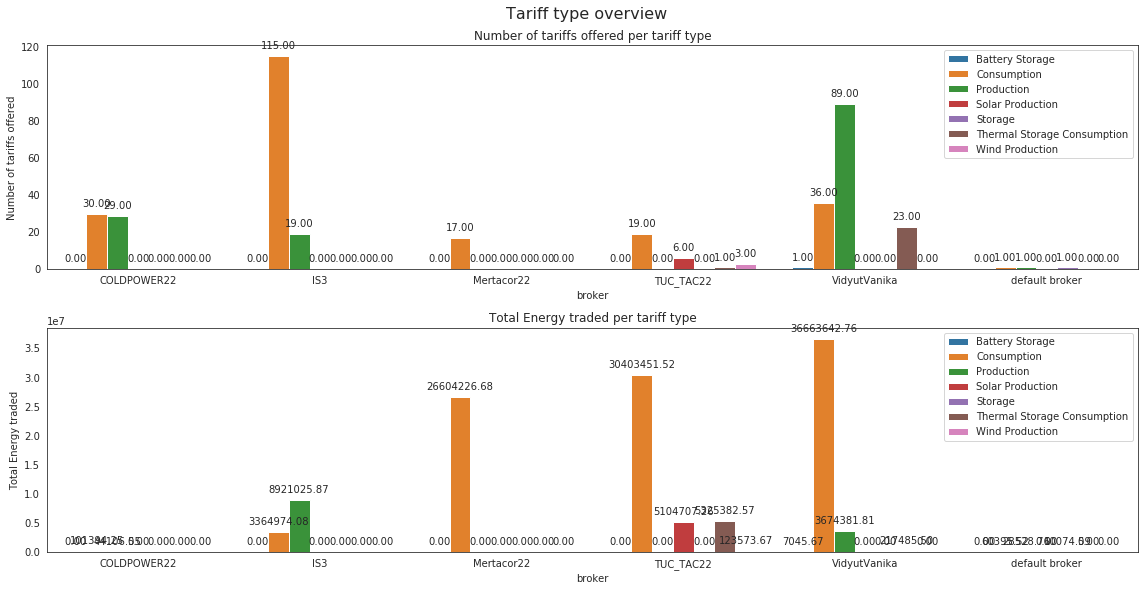

In [4]:
def add_value_labels(ax, spacing=5):
        """Add labels to the end of each bar in a bar chart.

        Arguments:
            ax (matplotlib.axes.Axes): The matplotlib object containing the axes
                of the plot to annotate.
            spacing (int): The distance between the labels and the bars.
        """

        # For each bar: Place a label
        for rect in ax.patches:
            # Get X and Y placement of label from rect.
            y_value = rect.get_height()
            x_value = rect.get_x() + rect.get_width() / 2

            # Number of points between bar and label. Change to your liking.
            space = spacing
            # Vertical alignment for positive values
            va = 'bottom'

            # If value of bar is negative: Place label below bar
            if y_value < 0:
                # Invert space to place label below
                space *= -1
                # Vertically align label at top
                va = 'top'

            # Use Y value as label and format number with one decimal place
            label = "{:.2f}".format(y_value)
            if label == "0.0":
                label = ""
                

            # Create annotation
            ax.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(0, space),          # Vertically shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                ha='center',                # Horizontally center label
                va=va)                      # Vertically align label differently for
                                            # positive and negative values.

tf_type_dist = tariff_transactions[['broker-name', 'tariff-id', 'tariff-type'
                                , 'transaction-kWh', 'customer-name', 'customer-count']].copy()
#tf_type_dist = tf_type_dist[tf_type_dist['customer-name'] == 'residential_ev']

tf_type_count = pd.DataFrame(tf_type_dist[['broker-name', 'tariff-type', 'tariff-id']]
                             .groupby(by = ['broker-name', 'tariff-type'])['tariff-id'].nunique())
tf_type_count = tf_type_count.reset_index()
tf_type_count.columns = ['broker', 'tariff-type', 'count']

tf_type_energy = pd.DataFrame(tf_type_dist[['broker-name', 'tariff-type', 'transaction-kWh']]
                              .groupby(by = ['broker-name', 'tariff-type']).sum())
tf_type_energy = tf_type_energy.reset_index()
tf_type_energy.columns = ['broker', 'tariff-type', 'energy']
tf_type_energy['energy'] = tf_type_energy['energy'].apply(lambda x: abs(x))

tf_type_count = tf_type_count.pivot(columns='tariff-type', index='broker')
tf_type_count.columns = tf_type_count.columns.swaplevel().map(' '.join)
tf_type_count = tf_type_count.replace(np.nan,0)
tf_type_count = tf_type_count.reset_index()

tf_type_energy = tf_type_energy.pivot(columns='tariff-type', index='broker')
tf_type_energy.columns = tf_type_energy.columns.swaplevel().map(' '.join)
tf_type_energy = tf_type_energy.replace(np.nan,0)
tf_type_energy = tf_type_energy.reset_index()

tf_types_count = tf_type_count.loc[:, tf_type_count.columns != "broker"]
tf_types_energy = tf_type_energy.loc[:, tf_type_energy.columns != "broker"]

df_melt_count = pd.melt(tf_type_count, id_vars=['broker'], value_vars=tf_types_count.columns.tolist())

df_melt_energy = pd.melt(tf_type_energy, id_vars=['broker'], value_vars=tf_types_energy.columns.tolist())

count_dict = {'BATTERY_STORAGE count': 'Battery Storage', 'PRODUCTION count': 'Production', 'STORAGE count': 'Storage'
                      , 'CONSUMPTION count': 'Consumption', 'THERMAL_STORAGE_CONSUMPTION count' : 'Thermal Storage Consumption'
                      , 'SOLAR_PRODUCTION count' : 'Solar Production', 'WIND_PRODUCTION count': 'Wind Production'}
energy_dict = {'BATTERY_STORAGE energy': 'Battery Storage', 'PRODUCTION energy': 'Production', 'STORAGE energy': 'Storage'
                      , 'CONSUMPTION energy': 'Consumption', 'THERMAL_STORAGE_CONSUMPTION energy' : 'Thermal Storage Consumption'
                      , 'SOLAR_PRODUCTION energy' : 'Solar Production', 'WIND_PRODUCTION energy': 'Wind Production'}

count_list = [count_dict[item] for item in tf_types_count.columns.tolist()]
energy_list = [energy_dict[item] for item in tf_types_energy.columns.tolist()]


sns.set_style("white")


f, axes = plt.subplots(2,1, figsize = (16,8))

a = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_count, ax = axes[0])
b = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_energy, ax = axes[1])

new_labels = count_list
                                               
h, l = a.get_legend_handles_labels()
a.legend(h, new_labels )

new_labels = energy_list

h, l = b.get_legend_handles_labels()
b.legend(h, new_labels)

add_value_labels(a)
add_value_labels(b)

axes[0].set(ylabel="Number of tariffs offered")
axes[1].set(ylabel="Total Energy traded")

mid = (f.subplotpars.right + f.subplotpars.left)/2

axes[0].set_title("Number of tariffs offered per tariff type")
axes[1].set_title("Total Energy traded per tariff type")

f.suptitle('Tariff type overview', y = 1.02, fontsize = 16, x = mid)
f.tight_layout()


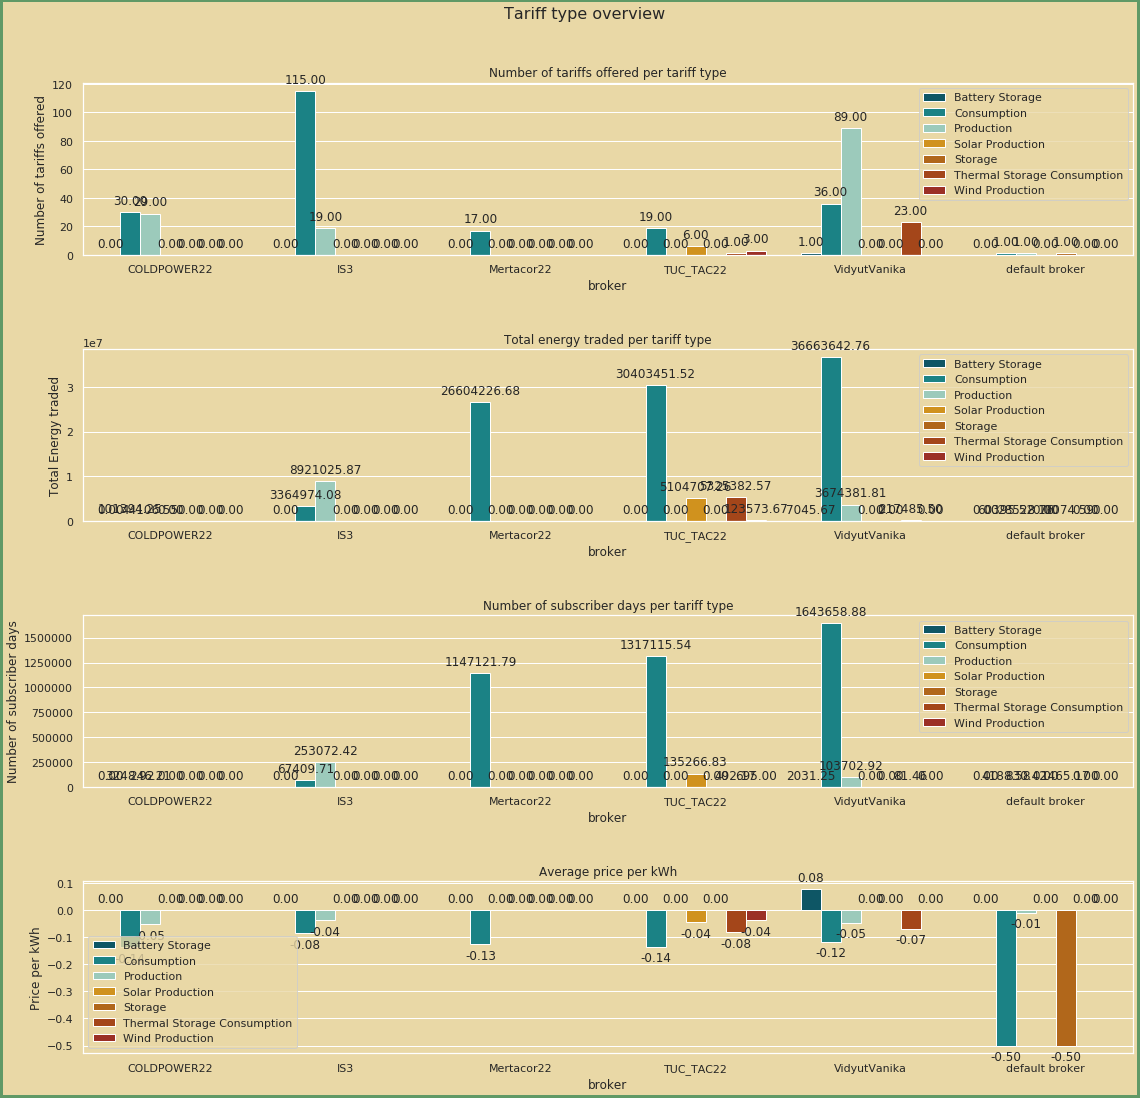

In [5]:
tf_type_dist = tariff_transactions[['timeslot', 'broker-name', 'tariff-id', 'tariff-type'
                                , 'transaction-kWh', 'customer-name', 'customer-count']].copy()


tf_type_count = pd.DataFrame(tf_type_dist[['broker-name', 'tariff-type', 'tariff-id']]
                             .groupby(by = ['broker-name', 'tariff-type'])['tariff-id'].nunique())
tf_type_count = tf_type_count.reset_index()
tf_type_count.columns = ['broker', 'tariff-type', 'count']

tf_type_count = tf_type_count.pivot(columns='tariff-type', index='broker')
tf_type_count.columns = tf_type_count.columns.swaplevel().map(' '.join)
tf_type_count = tf_type_count.replace(np.nan,0)
tf_type_count = tf_type_count.reset_index()

tf_types_count = tf_type_count.loc[:, tf_type_count.columns != "broker"]
df_melt_count = pd.melt(tf_type_count, id_vars=['broker'], value_vars=tf_types_count.columns.tolist())


#tf_type_dist = tf_type_dist[tf_type_dist['customer-name'] == 'residential_ev']
tf_type_energy = pd.DataFrame(tf_type_dist[['broker-name', 'tariff-type', 'transaction-kWh']]
                              .groupby(by = ['broker-name', 'tariff-type']).sum())
tf_type_energy = tf_type_energy.reset_index()
tf_type_energy.columns = ['broker', 'tariff-type', 'energy']
tf_type_energy['energy'] = tf_type_energy['energy'].apply(lambda x: abs(x))

tf_type_energy = tf_type_energy.pivot(columns='tariff-type', index='broker')
tf_type_energy.columns = tf_type_energy.columns.swaplevel().map(' '.join)
tf_type_energy = tf_type_energy.replace(np.nan,0)
tf_type_energy = tf_type_energy.reset_index()

tf_types_energy = tf_type_energy.loc[:, tf_type_energy.columns != "broker"]
df_melt_energy = pd.melt(tf_type_energy, id_vars=['broker'], value_vars=tf_types_energy.columns.tolist())


# after checking: each customer appears in each timeslot atleast once
tf_type_subs = tf_type_dist[['timeslot'
                                , 'broker-name', 'tariff-id'
                                , 'tariff-type', 'customer-name'
                                , 'customer-count']
                              ][tf_type_dist['customer-count'] > 0].copy()
tf_type_subs = tf_type_subs.drop_duplicates(keep='first')
tf_type_subs = tf_type_subs[['customer-count', 'broker-name', 'tariff-type']].groupby(by = ['broker-name', 'tariff-type']).sum()
tf_type_subs = tf_type_subs.reset_index()
tf_type_subs.columns = ['broker', 'tariff-type', 'count']
tf_type_subs['count'] = tf_type_subs['count'].apply(lambda x: round(x/24, 2))

tf_type_subs = tf_type_subs.pivot(columns='tariff-type', index='broker')
tf_type_subs.columns = tf_type_subs.columns.swaplevel().map(' '.join)
tf_type_subs = tf_type_subs.replace(np.nan,0)
tf_type_subs = tf_type_subs.reset_index()

tf_types_subs = tf_type_subs.loc[:, tf_type_subs.columns != "broker"]
df_melt_subs = pd.melt(tf_type_subs, id_vars=['broker'], value_vars=tf_types_subs.columns.tolist())




# no publish since this affects the brokers payments only
tf_df = tariff_transactions[tariff_transactions['transaction-type'] != 'PUBLISH'].copy()
tf_df['transaction-kWh'] = tf_df.apply(lambda x: 0 if ((x['transaction-regulation'] == 1) & (x['transaction-type'] == "PRODUCE")) else x['transaction-kWh'], axis = 1)

tf_type_price = pd.DataFrame(tf_df[['broker-name', 'tariff-type', 'transaction-kWh', 'transaction-charge']]
                              .groupby(by = ['broker-name', 'tariff-type']).sum())
tf_type_price = tf_type_price.reset_index()
tf_type_price.columns = ['broker', 'tariff-type', 'energy', 'price']
tf_type_price['avg_price'] = tf_type_price['price']/tf_type_price['energy']
tf_type_price2 = tf_type_price.copy()
tf_type_price = tf_type_price.drop(columns=['energy', 'price'])

tf_type_price = tf_type_price.pivot(columns='tariff-type', index='broker')
tf_type_price.columns = tf_type_price.columns.swaplevel().map(' '.join)
tf_type_price = tf_type_price.replace(np.nan,0)
tf_type_price = tf_type_price.reset_index()

tf_types_price = tf_type_price.loc[:, tf_type_price.columns != "broker"]
df_melt_price = pd.melt(tf_type_price, id_vars=['broker'], value_vars=tf_types_price.columns.tolist())


count_dict = {'BATTERY_STORAGE count': 'Battery Storage', 'PRODUCTION count': 'Production', 'STORAGE count': 'Storage', 'CONSUMPTION count': 'Consumption', 'THERMAL_STORAGE_CONSUMPTION count' : 'Thermal Storage Consumption', 'SOLAR_PRODUCTION count' : 'Solar Production', 'WIND_PRODUCTION count': 'Wind Production'}
energy_dict = {'BATTERY_STORAGE energy': 'Battery Storage', 'PRODUCTION energy': 'Production', 'STORAGE energy': 'Storage', 'CONSUMPTION energy': 'Consumption', 'THERMAL_STORAGE_CONSUMPTION energy' : 'Thermal Storage Consumption', 'SOLAR_PRODUCTION energy' : 'Solar Production', 'WIND_PRODUCTION energy': 'Wind Production'}
price_dict = {'BATTERY_STORAGE avg_price': 'Battery Storage', 'PRODUCTION avg_price': 'Production', 'STORAGE avg_price': 'Storage', 'CONSUMPTION avg_price': 'Consumption', 'THERMAL_STORAGE_CONSUMPTION avg_price' : 'Thermal Storage Consumption', 'SOLAR_PRODUCTION avg_price' : 'Solar Production', 'WIND_PRODUCTION avg_price': 'Wind Production'}


count_list = [count_dict[item] for item in tf_types_count.columns.tolist()]
energy_list = [energy_dict[item] for item in tf_types_energy.columns.tolist()]
subs_list = [count_dict[item] for item in tf_types_subs.columns.tolist()]
price_list = [price_dict[item] for item in tf_types_price.columns.tolist()]


#sns.set_style("white")

my_palette = sns.color_palette(['#005f73', '#0a9396', '#94d2bd'
                                , '#ee9b00', '#ca6702', '#bb3e03'
                                , '#ae2012', '#9b2226', '#9DC08B'
                                , '#9DC08B', '#9DC08B'])

sns.set(rc={'axes.facecolor':'#e9d8a6', 'figure.facecolor':'#e9d8a6'})

f, axes = plt.subplots(4,1, figsize = (16,15))

a = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_count, ax = axes[0], palette=my_palette)
b = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_energy, ax = axes[1], palette=my_palette)
c = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_subs, ax = axes[2], palette=my_palette)
d = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_price, ax = axes[3], palette=my_palette)


new_labels = count_list                                        
h, l = a.get_legend_handles_labels()
a.legend(h, new_labels )

new_labels = energy_list
h, l = b.get_legend_handles_labels()
b.legend(h, new_labels)

new_labels = subs_list
h, l = c.get_legend_handles_labels()
c.legend(h, new_labels)

new_labels = price_list
h, l = c.get_legend_handles_labels()
d.legend(h, new_labels)

add_value_labels(a)
add_value_labels(b)
add_value_labels(c)
add_value_labels(d)

axes[0].set(ylabel="Number of tariffs offered")
axes[1].set(ylabel="Total Energy traded")
axes[2].set(ylabel="Number of subscriber days")
axes[3].set(ylabel="Price per kWh")

mid = (f.subplotpars.right + f.subplotpars.left)/2

axes[0].set_title("Number of tariffs offered per tariff type")
axes[1].set_title("Total energy traded per tariff type")
axes[2].set_title("Number of subscriber days per tariff type")
axes[3].set_title("Average price per kWh")

f.subplots_adjust(top=0.85, bottom=0.15, left=0.2, hspace=2)
f.patch.set_linewidth(6)
f.patch.set_edgecolor('#609966')



# When saving the figure, the figure patch parameters are overwritten (WTF?).
# Hence we need to specify them again in the save command.
# fig.savefig('test.png', edgecolor=fig.get_edgecolor())

f.suptitle('Tariff type overview', y = 1.02, fontsize = 16, x = mid)
f.tight_layout()

f.savefig("subplots_with_border.png")

Text(0.5125, 1.02, 'test')

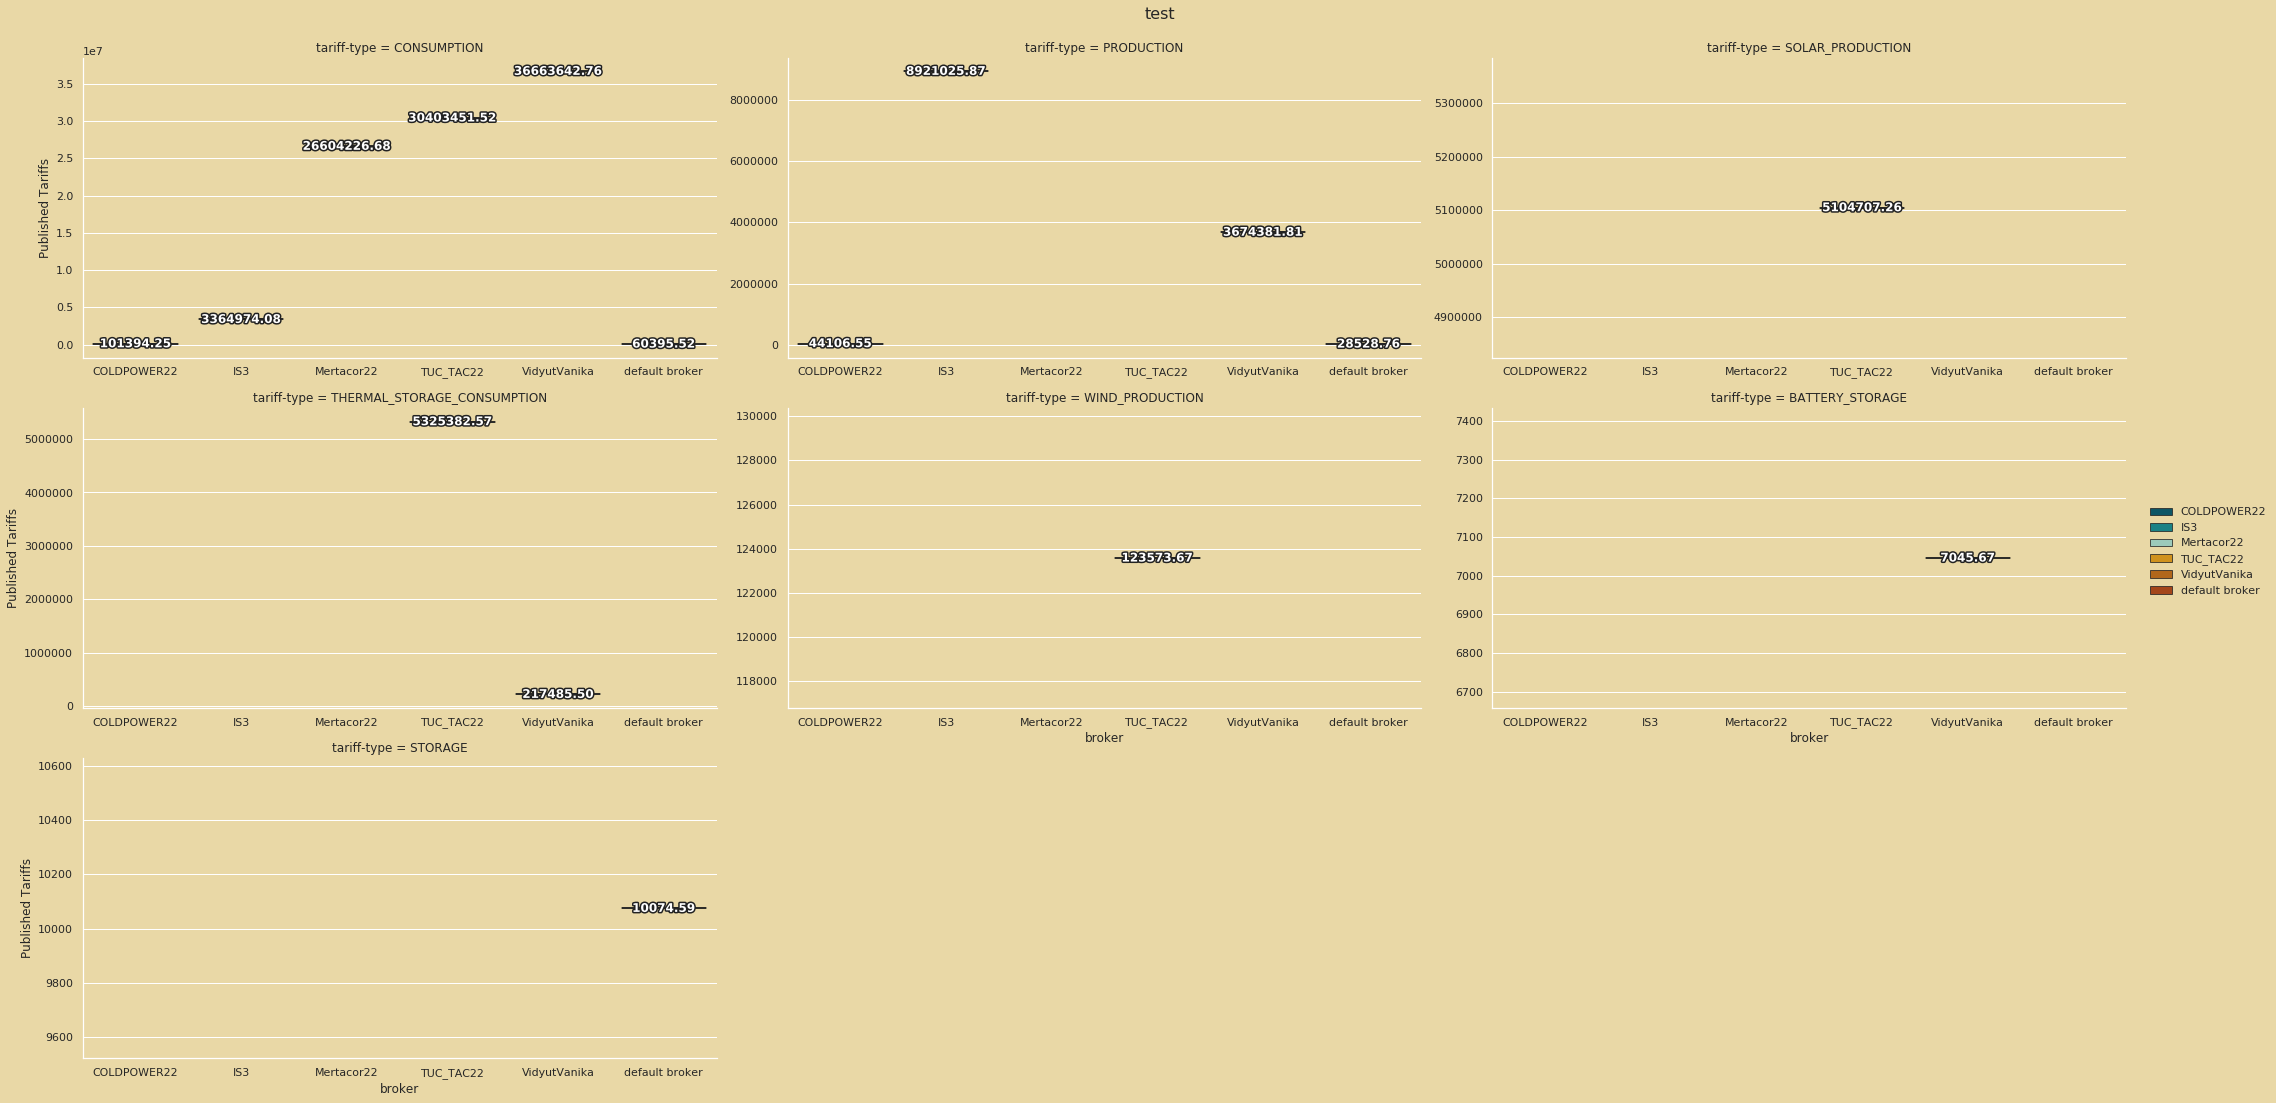

In [57]:
tf_type_energy = pd.DataFrame(tf_type_dist[['broker-name', 'tariff-type', 'transaction-kWh']]
                              .groupby(by = ['broker-name', 'tariff-type']).sum())
tf_type_energy = tf_type_energy.reset_index()
tf_type_energy.columns = ['broker', 'tariff-type', 'energy']
tf_type_energy['energy'] = tf_type_energy['energy'].apply(lambda x: abs(x))

g = sns.catplot(
    data=tf_type_energy, x='broker', y='energy',
    col='tariff-type', kind='box', col_wrap=3, palette = my_palette, hue='broker', dodge=False, sharey = False, height=5, aspect=2
)
g.add_legend()
for ax in g.axes:
    ax.set_xticklabels(tf_type_energy['broker'].unique())
    ax.tick_params(labelbottom=True)
    g.set_ylabels('Published Tariffs')
    
def add_median_labels(ax, fmt='.2f'):
        lines = ax.get_lines()
        boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
        lines_per_box = int(len(lines) / len(boxes))
        for median in lines[4:len(lines):lines_per_box]:
            x, y = (data.mean() for data in median.get_data())
            # choose value depending on horizontal or vertical plot orientation
            value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
            text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                           fontweight='bold', color='white')
            # create median-colored border around white text for contrast
            text.set_path_effects([
                path_effects.Stroke(linewidth=3, foreground=median.get_color()),
                path_effects.Normal(),
            ])

for ax in g.axes:
    add_median_labels(ax)


g.fig.suptitle('test', y = 1.02, fontsize = 16, x = mid)

In [21]:
# no publish since this affects the brokers payments only
tf_df = tariff_transactions[tariff_transactions['transaction-type'] != 'PUBLISH'].copy()
tf_df['transaction-kWh'] = tf_df.apply(lambda x: 0 if ((x['transaction-regulation'] == 1) & (x['transaction-type'] == "PRODUCE")) else x['transaction-kWh'], axis = 1)




In [50]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

tf_type_price = pd.DataFrame(tf_df[['broker-name', 'tariff-type', 'transaction-kWh', 'transaction-charge', 'customer-name']]
                              .groupby(by = ['broker-name', 'tariff-type', 'customer-name']).sum())
tf_type_price = tf_type_price.reset_index()
tf_type_price.columns = ['broker', 'tariff-type', 'customer-name', 'energy', 'price']
tf_type_price = tf_type_price[tf_type_price['customer-name'] != ""]
tf_type_price['avg_price'] = tf_type_price.apply(lambda x: 0 if (x['energy'] == 0) else x['price']/x['energy'], axis = 1)
mean = tf_type_price['avg_price'].mean()
sd = tf_type_price['avg_price'].std()
tf_type_price = tf_type_price[(tf_type_price['avg_price'] <= mean + 6*sd) & (tf_type_price['avg_price'] >= mean - 6*sd)]

tf_type_price[tf_type_price['broker'] == "IS3"].sort_values(by = 'energy').head(50)

,broker,tariff-type,customer-name,energy,price,avg_price
21,IS3,CONSUMPTION,DowntownOffices,-763622.0200,59941.9905,-0.0785
49,IS3,CONSUMPTION,MedicalCenter-1,-558045.4600,37075.9801,-0.0664
22,IS3,CONSUMPTION,EastsideOffices,-539741.1700,39129.6683,-0.0725
19,IS3,CONSUMPTION,BrooksideHomes,-492118.6000,61860.2455,-0.1257
20,IS3,CONSUMPTION,CentervilleHomes,-438521.9000,46906.0654,-0.1070
23,IS3,CONSUMPTION,FrostyStorage,-327536.2800,20675.6979,-0.0631
24,IS3,CONSUMPTION,HextraChemical,-212141.0700,16046.5674,-0.0756
100,IS3,CONSUMPTION,Village 2 NS Base,-8053.5980,512.6296,-0.0637
102,IS3,CONSUMPTION,Village 2 SS Base,-4522.9530,321.0635,-0.0710
107,IS3,CONSUMPTION,sf3,-4338.4396,295.9237,-0.0682


In [54]:
tf_type_price[tf_type_price['broker'] == "TUC_TAC22"].sort_values(by = 'energy').head(50)

,broker,tariff-type,customer-name,energy,price,avg_price
418,TUC_TAC22,CONSUMPTION,residential_ev,-9488877.0364,1279686.7220,-0.1349
269,TUC_TAC22,CONSUMPTION,BrooksideHomes,-7135625.5900,962869.8464,-0.1349
428,TUC_TAC22,THERMAL_STORAGE_CONSUMPTION,FrostyStorage,-6525324.8552,527702.4400,-0.0809
270,TUC_TAC22,CONSUMPTION,CentervilleHomes,-5228522.9500,704383.5305,-0.1347
271,TUC_TAC22,CONSUMPTION,DowntownOffices,-2261222.9900,309103.9073,-0.1367
272,TUC_TAC22,CONSUMPTION,EastsideOffices,-2055099.7500,277996.0183,-0.1353
323,TUC_TAC22,CONSUMPTION,MedicalCenter-1,-1971164.7200,269581.3131,-0.1368
274,TUC_TAC22,CONSUMPTION,HextraChemical,-1847909.5200,250065.0499,-0.1353
273,TUC_TAC22,CONSUMPTION,FrostyStorage,-218308.8700,26945.6711,-0.1234
432,TUC_TAC22,THERMAL_STORAGE_CONSUMPTION,freezeco-2,-96484.6937,6483.3262,-0.0672


In [38]:
tf_type_price = pd.DataFrame(tf_df[['broker-name', 'tariff-type', 'transaction-kWh', 'transaction-charge', 'customer-name']]
                              .groupby(by = ['broker-name', 'tariff-type', 'customer-name']).sum())
tf_type_price = tf_type_price.reset_index()
tf_type_price.columns = ['broker', 'tariff-type', 'customer-name', 'energy', 'price']
tf_type_price = tf_type_price[tf_type_price['customer-name'] != ""]
tf_type_price['avg_price'] = tf_type_price.apply(lambda x: 0 if (x['energy'] == 0) else x['price']/x['energy'], axis = 1)
mean = tf_type_price['avg_price'].mean()
sd = tf_type_price['avg_price'].std()
tf_type_price = tf_type_price[(tf_type_price['avg_price'] <= mean + 3*sd) & (tf_type_price['avg_price'] >= mean - 3*sd)]
tf_type_price = tf_type_price.drop(columns=['energy', 'price'])
tf_type_price = tf_type_price.groupby(by= ['broker', 'tariff-type']).mean()
tf_type_price



avg_price
broker         tariff-type                           
COLDPOWER22    CONSUMPTION                    -0.2086
               PRODUCTION                     -0.0257
IS3            CONSUMPTION                    -0.1501
               PRODUCTION                     -0.0360
Mertacor22     CONSUMPTION                    -0.1264
TUC_TAC22      CONSUMPTION                    -0.1359
               SOLAR_PRODUCTION               -0.0434
               THERMAL_STORAGE_CONSUMPTION    -0.0847
               WIND_PRODUCTION                -0.0343
VidyutVanika   BATTERY_STORAGE                 0.0774
               CONSUMPTION                    -0.1680
               PRODUCTION                     -0.0432
               THERMAL_STORAGE_CONSUMPTION    -0.0993
default broker CONSUMPTION                    -0.3750
               PRODUCTION                     -0.0033
               STORAGE                        -0.1901

In [41]:
tf_type_price = pd.DataFrame(tf_df[['broker-name', 'tariff-type', 'transaction-kWh', 'transaction-charge', 'customer-name']]
                              .groupby(by = ['broker-name', 'tariff-type', 'customer-name']).sum())
tf_type_price = tf_type_price.reset_index()
tf_type_price.columns = ['broker', 'tariff-type', 'customer-name', 'energy', 'price']
tf_type_price = tf_type_price[tf_type_price['customer-name'] != ""]
tf_type_price['avg_price'] = tf_type_price.apply(lambda x: 0 if (x['energy'] == 0) else x['price']/x['energy'], axis = 1)
mean = tf_type_price['avg_price'].mean()
sd = tf_type_price['avg_price'].std()
tf_type_price = tf_type_price[(tf_type_price['avg_price'] <= mean + 3*sd) & (tf_type_price['avg_price'] >= mean - 3*sd)]
tf_type_price = tf_type_price.drop(columns=['energy', 'price'])
tf_type_price = tf_type_price.groupby(by= ['broker', 'tariff-type']).mean()
tf_type_price



avg_price
broker         tariff-type                           
COLDPOWER22    CONSUMPTION                    -0.2086
               PRODUCTION                     -0.0257
IS3            CONSUMPTION                    -0.1501
               PRODUCTION                     -0.0360
Mertacor22     CONSUMPTION                    -0.1264
TUC_TAC22      CONSUMPTION                    -0.1359
               SOLAR_PRODUCTION               -0.0434
               THERMAL_STORAGE_CONSUMPTION    -0.0847
               WIND_PRODUCTION                -0.0343
VidyutVanika   BATTERY_STORAGE                 0.0774
               CONSUMPTION                    -0.1680
               PRODUCTION                     -0.0432
               THERMAL_STORAGE_CONSUMPTION    -0.0993
default broker CONSUMPTION                    -0.3750
               PRODUCTION                     -0.0033
               STORAGE                        -0.1901

In [68]:
tariff_transactions[(tariff_transactions['broker-name'] == "TUC_TAC22") & (tariff_transactions['transaction-type'] == "PUBLISH")]["transaction-charge"].sum()
tariff_transactions[(tariff_transactions['broker-name'] == "IS3")]["transaction-charge"].sum()

-381808.55070461164

transaction-type,broker-name,tariff-type,net_signup,group
0,default broker,CONSUMPTION,50263,1
1,default broker,PRODUCTION,7093,1
2,default broker,STORAGE,10162,1
3,COLDPOWER22,CONSUMPTION,1,1
4,TUC_TAC22,CONSUMPTION,44679,1
...,...,...,...,...
261,IS3,PRODUCTION,1,24
262,Mertacor22,CONSUMPTION,-814,24
263,TUC_TAC22,CONSUMPTION,-346,24
264,VidyutVanika,CONSUMPTION,1160,24


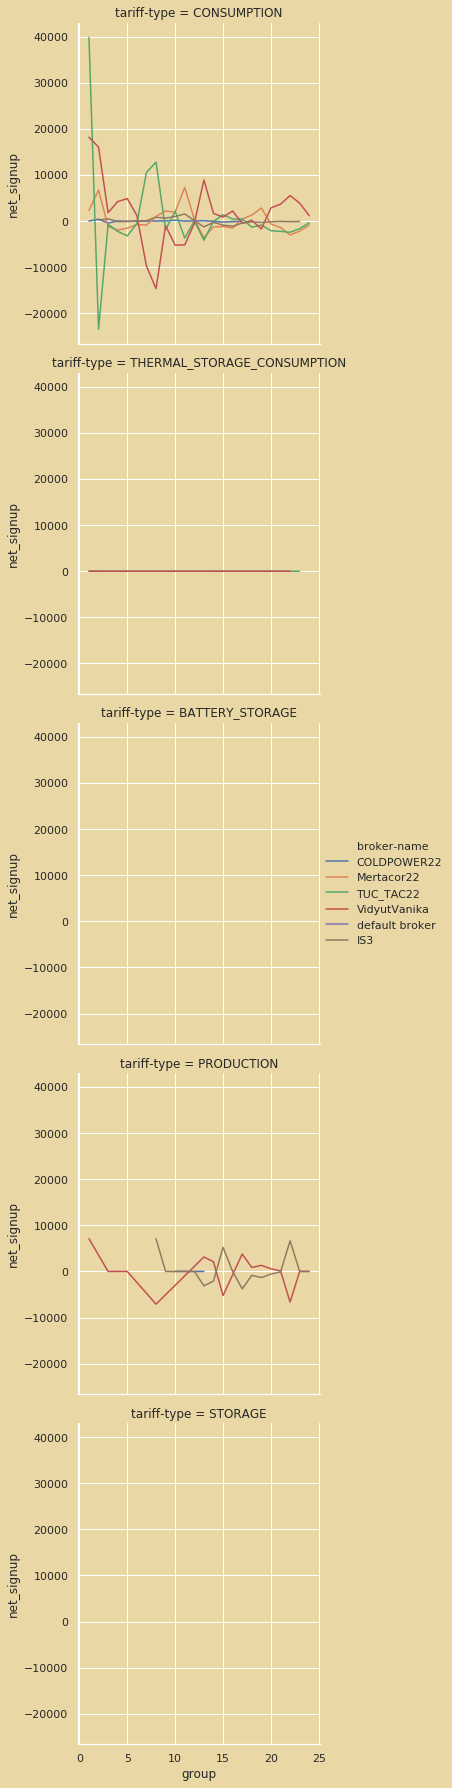

In [133]:
test = tariff_transactions[(tariff_transactions['transaction-type']
                 .isin(["SIGNUP", "WITHDRAW"]))][['timeslot', 'broker-name', 'transaction-type', 'tariff-type','customer-count']].groupby(by = ['timeslot', 'broker-name', 'tariff-type', 'transaction-type']).sum()
test = test.reset_index()
pivot_df = pd.pivot_table(test, values='customer-count', index=['timeslot', 'broker-name', 'tariff-type'], columns=['transaction-type'], fill_value=0)
pivot_df = pivot_df.reset_index()
pivot_df['net_signup'] = pivot_df['SIGNUP'] - pivot_df['WITHDRAW']
pivot_df = pivot_df[pivot_df['timeslot'] < 600]
pivot_df['group'] = (pivot_df['timeslot'] - 360) // 10 + 1
pivot_df = pivot_df.drop(columns=['SIGNUP', 'WITHDRAW', 'timeslot'])
# Aggregate the count for each group
result = pivot_df.groupby(by = ['group', 'broker-name', 'tariff-type']).sum()
result = result.reset_index()

sns.relplot(x="group", y="net_signup", hue="broker-name", row="tariff-type", kind="line", data=result, legend = "full")
pivot_df

In [75]:
tariff_transactions[(tariff_transactions['broker-name'] == "VidyutVanika") & (tariff_transactions['customer-name'] == "BrooksideHomes")]

,game,timeslot,broker-name,tariff-id,tariff-type,transaction-type,transaction-kWh,transaction-charge,transaction-regulation,customer-name,customer-count
962,finals_2022_1,361,VidyutVanika,300000080,CONSUMPTION,SIGNUP,0.0000,-0.0000,0,BrooksideHomes,9900
1020,finals_2022_1,362,VidyutVanika,300000080,CONSUMPTION,CONSUME,-7286.8400,908.3556,0,BrooksideHomes,9900
1021,finals_2022_1,362,VidyutVanika,300000080,CONSUMPTION,PERIODIC,0.0000,61.8750,0,BrooksideHomes,9900
1311,finals_2022_1,363,VidyutVanika,300000080,CONSUMPTION,CONSUME,-3382.2400,422.0968,0,BrooksideHomes,9900
1312,finals_2022_1,363,VidyutVanika,300000080,CONSUMPTION,PERIODIC,0.0000,61.8750,0,BrooksideHomes,9900
...,...,...,...,...,...,...,...,...,...,...,...
575664,finals_2022_1,1985,VidyutVanika,301398465,CONSUMPTION,PERIODIC,0.0000,10.0561,0,BrooksideHomes,2368
575668,finals_2022_1,1985,VidyutVanika,301765248,CONSUMPTION,CONSUME,-624.0700,93.0488,0,BrooksideHomes,2550
575669,finals_2022_1,1985,VidyutVanika,301765248,CONSUMPTION,PERIODIC,0.0000,10.6026,0,BrooksideHomes,2550
575671,finals_2022_1,1985,VidyutVanika,301826869,CONSUMPTION,CONSUME,-1019.3400,151.4087,0,BrooksideHomes,3015


In [ ]:
tf_type_price2 = tf_type_price.copy()
tf_type_price = tf_type_price.drop(columns=['energy', 'price'])

tf_type_price = tf_type_price.pivot(columns='tariff-type', index='broker')
tf_type_price.columns = tf_type_price.columns.swaplevel().map(' '.join)
tf_type_price = tf_type_price.replace(np.nan,0)
tf_type_price = tf_type_price.reset_index()

tf_types_price = tf_type_price.loc[:, tf_type_price.columns != "broker"]
df_melt_price = pd.melt(tf_type_price, id_vars=['broker'], value_vars=tf_types_price.columns.tolist())

In [7]:
tariff_transactions

,game,timeslot,broker-name,tariff-id,tariff-type,transaction-type,transaction-kWh,transaction-charge,transaction-regulation,customer-name,customer-count
0,finals_2022_1,360,default broker,1884,CONSUMPTION,SIGNUP,0.0000,-0.0000,0,Village 1 NS Base,30
1,finals_2022_1,360,default broker,1884,CONSUMPTION,SIGNUP,0.0000,-0.0000,0,Village 1 NS Controllable,30
2,finals_2022_1,360,default broker,1884,CONSUMPTION,SIGNUP,0.0000,-0.0000,0,Village 1 SS Base,10
3,finals_2022_1,360,default broker,1884,CONSUMPTION,SIGNUP,0.0000,-0.0000,0,Village 1 SS Controllable,10
4,finals_2022_1,360,default broker,1884,CONSUMPTION,SIGNUP,0.0000,-0.0000,0,Village 2 NS Base,30
...,...,...,...,...,...,...,...,...,...,...,...
576029,finals_2022_1,1985,Mertacor22,600025370,CONSUMPTION,CONSUME,-0.0000,0.0000,0,LowIncome-1_15,1
576030,finals_2022_1,1985,Mertacor22,600018563,CONSUMPTION,CONSUME,-1.1000,0.1246,0,LowIncome-1_16,1
576031,finals_2022_1,1985,TUC_TAC22,500000131,THERMAL_STORAGE_CONSUMPTION,CONSUME,0.0000,-0.0000,1,seafood-1,1
576032,finals_2022_1,1985,TUC_TAC22,500000131,THERMAL_STORAGE_CONSUMPTION,PRODUCE,76.6500,-5.2545,1,freezeco-2,1


In [51]:
df_melt_price.sort_values(by=['broker', 'variable'])

,broker,variable,value
0,COLDPOWER22,BATTERY_STORAGE avg_price,0.0000
6,COLDPOWER22,CONSUMPTION avg_price,-0.1365
12,COLDPOWER22,PRODUCTION avg_price,-0.0532
18,COLDPOWER22,SOLAR_PRODUCTION avg_price,0.0000
24,COLDPOWER22,STORAGE avg_price,0.0000
30,COLDPOWER22,THERMAL_STORAGE_CONSUMPTION avg_price,0.0000
36,COLDPOWER22,WIND_PRODUCTION avg_price,0.0000
1,IS3,BATTERY_STORAGE avg_price,0.0000
7,IS3,CONSUMPTION avg_price,-0.0843
13,IS3,PRODUCTION avg_price,-0.0362


In [55]:
tf_type_price2.sort_values(by=['broker', 'tariff-type'])

,broker,tariff-type,energy,price,avg_price
0,COLDPOWER22,CONSUMPTION,-101394.2487,13842.8213,-0.1365
1,COLDPOWER22,PRODUCTION,44106.5500,-2344.7577,-0.0532
2,IS3,CONSUMPTION,-3364974.0794,283816.7457,-0.0843
3,IS3,PRODUCTION,8921025.8700,-322908.5824,-0.0362
4,Mertacor22,CONSUMPTION,-26604226.6773,3382801.3608,-0.1272
5,TUC_TAC22,CONSUMPTION,-30403451.5158,4105563.6394,-0.1350
6,TUC_TAC22,SOLAR_PRODUCTION,5104707.2600,-221752.5990,-0.0434
7,TUC_TAC22,THERMAL_STORAGE_CONSUMPTION,-5325382.5746,556588.2234,-0.1045
8,TUC_TAC22,WIND_PRODUCTION,123573.6700,-4499.1422,-0.0364
9,VidyutVanika,BATTERY_STORAGE,-7045.6671,-6558.1720,0.9308


In [62]:
tariff_transactions[(tariff_transactions['tariff-type'] == 'BATTERY_STORAGE') & tariff_transactions['transaction-kWh'] != 0].tail(50)

,game,timeslot,broker-name,tariff-id,tariff-type,transaction-type,transaction-kWh,transaction-charge,transaction-regulation,customer-name,customer-count
575201,finals_2022_1,1983,VidyutVanika,300000755,BATTERY_STORAGE,PRODUCE,24.0586,-4.6914,1,b11,1
575202,finals_2022_1,1983,VidyutVanika,300000755,BATTERY_STORAGE,PRODUCE,24.0586,-4.6914,1,b12,1
575203,finals_2022_1,1983,VidyutVanika,300000755,BATTERY_STORAGE,PRODUCE,24.0586,-4.6914,1,b13,1
575204,finals_2022_1,1983,VidyutVanika,300000755,BATTERY_STORAGE,PRODUCE,24.0586,-4.6914,1,b14,1
575205,finals_2022_1,1983,VidyutVanika,300000755,BATTERY_STORAGE,PRODUCE,24.0586,-4.6914,1,b15,1
575206,finals_2022_1,1983,VidyutVanika,300000755,BATTERY_STORAGE,PRODUCE,24.0586,-4.6914,1,b16,1
575207,finals_2022_1,1983,VidyutVanika,300000755,BATTERY_STORAGE,PRODUCE,24.0586,-4.6914,1,b17,1
575208,finals_2022_1,1983,VidyutVanika,300000755,BATTERY_STORAGE,PRODUCE,24.0586,-4.6914,1,b18,1
575209,finals_2022_1,1983,VidyutVanika,300000755,BATTERY_STORAGE,PRODUCE,24.0586,-4.6914,1,b19,1
575210,finals_2022_1,1983,VidyutVanika,300000755,BATTERY_STORAGE,PRODUCE,24.0586,-4.6914,1,b20,1


In [22]:
tariff_transactions['transaction-type'].unique()

array(['SIGNUP', 'CONSUME', 'PRODUCE', 'WITHDRAW', 'PUBLISH', 'PERIODIC',
       'REVOKE'], dtype=object)

In [48]:
h, l = c.get_legend_handles_labels()


new_labels = [count_dict[item] for item in l]
new_labels

['Battery Storage',
 'Consumption',
 'Production',
 'Solar Production',
 'Storage',
 'Thermal Storage Consumption',
 'Wind Production']

In [40]:
tf_type_energy = pd.DataFrame(tf_type_dist[['broker-name', 'tariff-type', 'transaction-kWh']].groupby(by = ['broker-name', 'tariff-type']).sum())
tf_type_energy = tf_type_energy.reset_index()
tf_type_energy.columns = ['broker', 'tariff-type', 'energy']
tf_type_energy['energy'] = tf_type_energy['energy'].apply(lambda x: abs(x))

tf_type_energy = tf_type_energy.pivot(columns='tariff-type', index='broker')
tf_type_energy.columns = tf_type_energy.columns.swaplevel().map(' '.join)
tf_type_energy = tf_type_energy.replace(np.nan,0)
tf_type_energy = tf_type_energy.reset_index()

tf_types_energy = tf_type_energy.loc[:, tf_type_energy.columns != "broker"]

tariff_transactions[tariff_transactions["transaction-type"] == "WITHDRAW"]

#tariff_transactions["transaction-type"].unique()
#array(['SIGNUP', 'CONSUME', 'PRODUCE', 'WITHDRAW', 'PUBLISH', 'PERIODIC',
 #      'REVOKE'], dtype=object)
    
#get the number of subscriptions and revokes
    
#timeslot,  customer-count>0, customer-name, tariff-type

number of signups
number of revokes
per broker

tariff_transactions[["broker-name", "customer-count", "transaction-type",]]

,game,timeslot,broker-name,tariff-id,tariff-type,transaction-type,transaction-kWh,transaction-charge,transaction-regulation,customer-name,customer-count
398,finals_2022_1,360,default broker,1890,STORAGE,WITHDRAW,0.0,-0.0,0,sf3,1
400,finals_2022_1,360,default broker,1890,STORAGE,WITHDRAW,0.0,-0.0,0,fc2,1
402,finals_2022_1,360,default broker,1890,STORAGE,WITHDRAW,0.0,-0.0,0,MiddleIncome-1_4,1
404,finals_2022_1,360,default broker,1890,STORAGE,WITHDRAW,0.0,-0.0,0,MiddleIncome-1_10,1
406,finals_2022_1,360,default broker,1890,STORAGE,WITHDRAW,0.0,-0.0,0,MiddleIncome-2_0,1
...,...,...,...,...,...,...,...,...,...,...,...
574404,finals_2022_1,1981,COLDPOWER22,200012970,PRODUCTION,WITHDRAW,0.0,5.0,0,WindmillCoOp-1,5
574406,finals_2022_1,1981,COLDPOWER22,200012970,PRODUCTION,WITHDRAW,0.0,1.0,0,WindmillCoOp-2,1
574408,finals_2022_1,1981,TUC_TAC22,500023254,SOLAR_PRODUCTION,WITHDRAW,0.0,0.0,0,SolarLeasing,5280
574410,finals_2022_1,1981,Mertacor22,600022206,CONSUMPTION,WITHDRAW,0.0,-0.0,0,OfficeComplex 1 SS Base,3


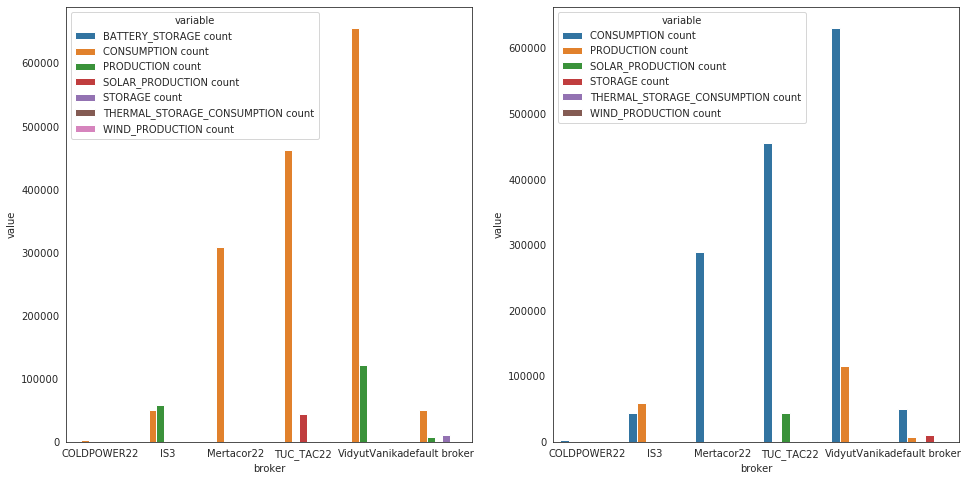

In [66]:
tf_type_subs = tariff_transactions[['broker-name', 'tariff-type', "transaction-type"
                              , 'customer-name', 'customer-count']].copy()
#tf_type_dist = tf_type_dist[tf_type_dist['customer-name'] == 'residential_ev']

tf_type_subs = tf_type_subs[(tf_type_subs["transaction-type"] == "SIGNUP") | (tf_type_subs["transaction-type"] == "WITHDRAW")]
tf_type_subs = tf_type_subs[["broker-name", "tariff-type"
                             , "transaction-type", "customer-count"]
                           ].groupby(by = ['broker-name', "tariff-type", "transaction-type" ]).sum()
tf_type_subs = tf_type_subs.reset_index()
tf_type_subs.columns = ['broker', 'tariff-type', 'transaction-type', 'count']

subs_sign = tf_type_subs[tf_type_subs["transaction-type"] == "SIGNUP"][['broker', 'tariff-type', 'count']].copy()
subs_withdraw = tf_type_subs[tf_type_subs["transaction-type"] == "WITHDRAW"][['broker', 'tariff-type', 'count']].copy()

subs_sign = subs_sign.pivot(columns='tariff-type', index='broker')
subs_sign.columns = subs_sign.columns.swaplevel().map(' '.join)
subs_sign = subs_sign.replace(np.nan,0)
subs_sign = subs_sign.reset_index()

subs_withdraw = subs_withdraw.pivot(columns='tariff-type', index='broker')
subs_withdraw.columns = subs_withdraw.columns.swaplevel().map(' '.join)
subs_withdraw = subs_withdraw.replace(np.nan,0)
subs_withdraw = subs_withdraw.reset_index()

subs_sign_count = subs_sign.loc[:, subs_sign.columns != "broker"]
subs_withdraw_count = subs_withdraw.loc[:, subs_withdraw.columns != "broker"]

df_melt_subs_sign = pd.melt(subs_sign, id_vars=['broker'], value_vars=subs_sign_count.columns.tolist())
df_melt_subs_withdraw = pd.melt(subs_withdraw, id_vars=['broker'], value_vars=subs_withdraw_count.columns.tolist())


f, axes = plt.subplots(1,2, figsize = (16,8))

sns.barplot(x='broker', y='value', hue='variable', data=df_melt_subs_sign, ax = axes[0])
sns.barplot(x='broker', y='value', hue='variable', data=df_melt_subs_withdraw, ax = axes[1])


In [200]:
tariff_transactions['customer-name'].unique()

array(['Village 1 NS Base', 'Village 1 NS Controllable',
       'Village 1 SS Base', 'Village 1 SS Controllable',
       'Village 2 NS Base', 'Village 2 NS Controllable',
       'Village 2 SS Base', 'Village 2 SS Controllable', 'BrooksideHomes',
       'CentervilleHomes', 'DowntownOffices', 'EastsideOffices',
       'FrostyStorage', 'HextraChemical', 'MedicalCenter-1',
       'MedicalCenter-2', 'SunnyhillSolar1', 'SunnyhillSolar2',
       'WindmillCoOp-1', 'WindmillCoOp-2', 'SolarLeasing',
       'OfficeComplex 1 NS Base', 'OfficeComplex 1 NS Controllable',
       'OfficeComplex 1 SS Base', 'OfficeComplex 1 SS Controllable',
       'OfficeComplex 2 NS Base', 'OfficeComplex 2 NS Controllable',
       'OfficeComplex 2 SS Base', 'OfficeComplex 2 SS Controllable',
       'seafood-1', 'seafood-2', 'freezeco-1', 'freezeco-2', 'freezeco-3',
       'residential_ev', 'sf2', 'sf3', 'fc2', 'fc3', 'b1', 'b2', 'b3',
       'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11', 'b12', 'b13',
       'b14'

In [113]:
tf_type_dist = tariff_transactions[['broker-name', 'tariff-id', 'tariff-type', 'transaction-kWh', 'customer-name', 'customer-count']].copy()

tf_type_count = pd.DataFrame(tf_type_dist[['broker-name', 'tariff-type', 'tariff-id']].groupby(by = ['broker-name', 'tariff-type'])['tariff-id'].nunique())
tf_type_count = tf_type_count.reset_index()
tf_type_count.columns = ['broker', 'tariff-type', 'count']

tf_type_energy = pd.DataFrame(tariff_type_dist[['broker-name', 'tariff-type', 'transaction-kWh']].groupby(by = ['broker-name', 'tariff-type']).sum())
tf_type_energy = tf_type_energy.reset_index()
tf_type_energy.columns = ['broker', 'tariff-type', 'energy']

# Use melt to reshape the dataframe
df_melt_count = pd.melt(tf_type_count, id_vars=['broker'], value_vars=['upReg', 'downReg'])
df_melt_energy = pd.melt(tf_type_energy, id_vars=['broker'], value_vars=['pUp_fromBroker', 'profit_x', 'pDown_toBroker', 'profit_y'])


# Create a bar plot

f, axes = plt.subplots(3,1, figsize = (20,24))

a = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_energy, ax=axes[0])
b = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_profit, ax=axes[1])
c = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_perKwh, ax=axes[2])

,broker,tariff-type,count
0,COLDPOWER22,CONSUMPTION,30
1,COLDPOWER22,PRODUCTION,29
2,IS3,CONSUMPTION,115
3,IS3,PRODUCTION,19
4,Mertacor22,CONSUMPTION,17
5,TUC_TAC22,CONSUMPTION,19
6,TUC_TAC22,SOLAR_PRODUCTION,6
7,TUC_TAC22,THERMAL_STORAGE_CONSUMPTION,1
8,TUC_TAC22,WIND_PRODUCTION,3
9,VidyutVanika,BATTERY_STORAGE,1


In [64]:
# .groupby(by = ['broker-name', 'tariff-id', 'tariff-type', 'customer-name', 'customer-count']).sum()
tariff_type_dist = tariff_transactions[['broker-name', 'tariff-id', 'tariff-type', 'transaction-kWh', 'customer-name', 'customer-count']].copy()
testdf = (tariff_type_dist[['broker-name', 'tariff-id']]
       .groupby(['broker-name', 'tariff-id'], as_index=False).size())


testdf = pd.DataFrame(testdf).reset_index()
testdf

,broker-name,tariff-id,0
0,COLDPOWER22,200000009,1
1,COLDPOWER22,200000012,43
2,COLDPOWER22,200000015,28
3,COLDPOWER22,200000158,345
4,COLDPOWER22,200000441,121
...,...,...,...
386,VidyutVanika,302007471,1
387,VidyutVanika,302007520,73
388,default broker,1884,118
389,default broker,1887,972


In [38]:
tariff_type_dist = tariff_transactions[['broker-name', 'tariff-id', 'tariff-type', 'transaction-kWh', 'customer-name', 'customer-count']].groupby(by = ['broker-name', 'tariff-id', 'tariff-type', 'customer-name', 'customer-count']).sum().copy()
tariff_type_dist[['broker-name', 'tariff-id']].groupby(['broker-name', 'tariff-id']).count()





KeyError: "None of [Index(['broker-name', 'tariff-id'], dtype='object')] are in the [columns]"